# Topic Mining: Document Classification 
### Josh Iden
Watch: [Presentation](https://youtu.be/TLKk7RGAOHg)

## Assignment 

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  [UCI Machine Learning Repository: Spambase Data Set](http://archive.ics.uci.edu/ml/datasets/Spambase).

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

## Introduction

As this is my first stab at document classification, I decided to use the suggested dataset and perform predictions using logistic regression methods on the dataset. 

### Loading the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import re

%matplotlib inline

In [2]:
# loading the column names from spambase.names

with open('spambase.names') as f:
    lines = f.readlines()
    
# all names start with alphanumeric up to a colon, extracting them
names = [re.findall('\w+[^:]', line)[0] for line in lines if line[0].isalpha()]
# hard coding the last name: class
names.append('email')
names[-5:]

['char_freq_#',
 'capital_run_length_average',
 'capital_run_length_longest',
 'capital_run_length_total',
 'email']

After previewing the data files provided at the above repository, I used some regex in a list comprehension to isolate feature (column) names, and then hard-coded in the class feature, then for readability, converting the 0-1 `class` value to "not spam" or "spam". 

In [3]:
# loading the file from spambase.data

df = pd.read_csv('spambase.data', names=names, index_col=False)
df.email.replace({0: "not spam", 1: "spam"}, inplace=True)
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,email
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,spam
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,spam
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,spam
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,spam


Confirming no null values are present in the data:

In [4]:
df.isnull().values.any()

False

### Exploratory Data Analysis

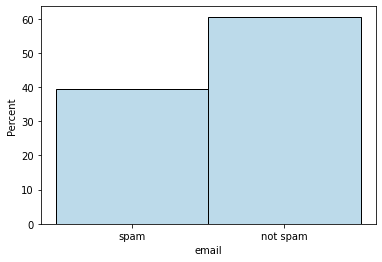

In [5]:
sns.set_palette("Paired")
sns.histplot(x = df['email'], stat = 'percent');

In [6]:
_ns, _s = round(df.email.value_counts(normalize=True) * 100, 2)

print("Percent spam: {}%".format(_s))
print("Percent not spam: {}%".format(_ns))

Percent spam: 39.4%
Percent not spam: 60.6%


The distribution of spam versus not spam gives us a baseline to compare our predictions.

### Making Predictons

The `scikit-learn` module provides a wealth of packages to perform regression. First I split the data 80/20, 80% to my training set, 20% to my testing set. Then I instantiate a pipeline and fit the model to make predictions.

In [7]:
# split the data 
y = df['email']
X = df.drop('email', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=123)

In [8]:
# Instantiate Standard Scaler and Logistic Regression
scaler = StandardScaler()
logreg = LogisticRegression(fit_intercept=False, C=1e16, solver='liblinear')# Creating a classifier pipeline 
clf = Pipeline([('ss', scaler), 
                ('log', logreg)])

clf.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('log',
                 LogisticRegression(C=1e+16, fit_intercept=False,
                                    solver='liblinear'))])

In [9]:
# Get the prediction accuracy
predictions = clf.predict(X_test)
print("Prediction accuracy: {}%".format(round(clf.score(X_test, y_test)*100, 2)))

Prediction accuracy: 93.27%


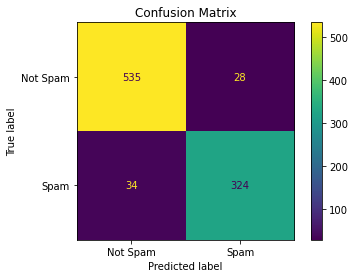

In [10]:
labels = [i.title() for i in list(clf.classes_)]
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix")
plt.show();

In [11]:
print(classification_report(y_test, predictions, output_dict=False))

              precision    recall  f1-score   support

    not spam       0.94      0.95      0.95       563
        spam       0.92      0.91      0.91       358

    accuracy                           0.93       921
   macro avg       0.93      0.93      0.93       921
weighted avg       0.93      0.93      0.93       921



As we can see, the model is not perfect; 100% precision and recall would indicate there are no false positives, and no false negatives, which we can see is not the case based on the confusion matrix. The F1-score is an average of precision and recall. Ideally if we are trying to identify actual spam as opposed to just "not spam", we would want the precision (ie true positive) on the spam to be higher than the "not spam". Both precision and recall are higher for the "not spam" category, which is less desirable. Let's see how the proportion of the emails compares between the predictions and the original data:

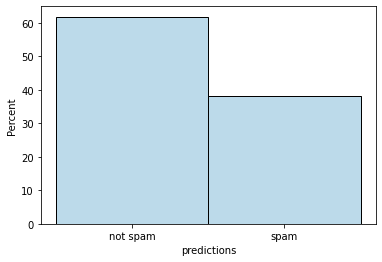

In [12]:
sns.histplot(predictions, stat = 'percent')
plt.xlabel('predictions');

In [13]:
_pns, _ps = round(pd.Series(predictions).value_counts(normalize=True)*100,1)
print("Percent spam : {}%".format(_ps))
print("Percent not spam: {}%".format(_pns))

Percent spam : 38.2%
Percent not spam: 61.8%


Comparing with the original data:

In [14]:
o_prop = pd.Series(round(df.email.value_counts(normalize=True) * 100, 2), name = 'original_data')
p_prop = round(pd.Series(predictions, name = 'predictions').value_counts(normalize=True) * 100, 1)

In [15]:
c_prop = pd.concat([o_prop, p_prop], axis=1)
c_prop['diff'] = c_prop.predictions - c_prop.original_data
c_prop

,original_data,predictions,diff
not spam,60.6,61.8,1.2
spam,39.4,38.2,-1.2


So the proportion of spam/not spam between the predictions and the original data is off by about 1.2%. 

### Conclusion 

The data is fairly predictive utilizing all features in the dataset. The degree to which one is willing to accept errors or percentage accuracy is dependent on the application of the predictive model. For example, medical models generally demand far higher accuracy to be useful. As a predictive model for spam classification however, a nearly 94% accuracy is significant. One of the takeaways from this assignment is how building a predictive model also provides an additional step in determining which features have predictive significance. While this assignment built a "kitchen-sink" model including all features, additional feature selection and transformation may allow better tuning of the model to achieve a higher predictive accuracy. 